# Feature selection with L1 Regularization

* Consider a supervised learning setting where you have data $\mathcal{D} = \{(X, Y)\}$, where $X \in \mathbb{R}^{NXD}$. $N$  - num of datapoints and $D$ - num of features. Many of the features may be irrelevant for the task at hand.
* Typically when there are more features than samples, ie. $D >> N$, a simple linear regression model is prone to overfit.
* As we have seen before, regularization is one of the tools in our toolbox to combat overfitting. Here we will see how they do that and how $L1$ regularization can be used for feature selection.

## Tasks

1. Load the data "cancer_reg.csv" data.
2. Preprocess your data particularly making sure there are no nan values.
3. Since we want to study overfitting and how to solve it, we are going to add correlated features to our data to increase the number of features. These new features are usless, we will see how to remove them with $L1$ regularization. We will take only small portion of the data for training (It could be 20% for training). This will make our model overfit, later on we will regularize the model to solve the overfitting.
4. Define your linear regression model with and without regularization ($L1$ and $L2$)
5. Train and test your linear regression models (without regularization) till it overfits the data. Plot the learning curves for training and testing (You may ignore loss values for the first 10 epochs)
6. Train and test again with $L1$ regularization and visually inspect the effects. Plot the weights for each model (using matplotlib stem plot). Do you see any difference between them?
7. In the case of the $L1$ **(Lasso) **regularization, set a small threshold and remove all features of the data corresponding to the weights with values below this threshold. Train a new model with remaining features (with or without regularization)
8. Train and test again with $L2$ regularization **(Ridge)** and visually inspect the effects. Plot the weights for each model (using matplotlib stem plot). Do you see any difference between them?
9. Train and test again with $L1$ + $L2$ regularization **(Elastic Net)** and visually inspect the effects. Plot the weights for each model (using matplotlib stem plot). Do you see any difference between them?


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the data "cancer_reg.csv" data from here. A slightly modified copy will be shared with you on workplace. Target is labeled "TARGET_deathRate".

#Dataset Class:

It is always recommended to create a seperate class to prepare the data. Usually we use the Dataset class for:


1.   Downloading the data, if needed.
2.   Preprocessing the data.
3.   Spliting the data.




In [ ]:
class Dataset:
  def __init__(self, path, test_size=0.85):
    self.test_size = test_size
    if path==None:
        self.train_inputs = []
        self.test_inputs = []
        self.train_targets = []
        self.test_targets = []
    else:
        self.initialize(path)
    
  def initialize(self, path):
    data = pd.read_csv(path,  encoding='latin-1')
    #Fill all the NAN values with the mean
    for col in data.columns:
      if data[col].isna().sum()!=0:
        data[col][data[col].isna()] = data[col].mean()
        
    data = data.drop(['Geography', 'binnedInc'], axis=1)
    
    target = data["TARGET_deathRate"].values
    inputs = data.drop("TARGET_deathRate", axis=1)


    #here we add more features
    for col in inputs.columns:
      for i in range(2,10):
        new_col = f'{col}_{i}' 
        inputs[new_col] =  inputs[col]**i

    inputs = inputs.values
    inputs = inputs/inputs.max(axis=0)
    self.target = target
    self.inputs = inputs
    
    #Shuffle before splitting the data
    indices = np.arange(len(self.target))
    np.random.shuffle(indices)
    test_num_points = int(self.test_size * len(indices))
    test_indices = indices[:test_num_points]
    train_indices = indices[test_num_points:]

    self.train_inputs = self.inputs[train_indices]
    self.test_inputs = self.inputs[test_indices]
    self.train_targets = self.target[train_indices]
    self.test_targets = self.target[test_indices]
  


    

In [ ]:
dataset = Dataset("cancer_reg.csv") #"cancer-mortality-rate.csv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
data = pd.read_csv('cancer_reg.csv',  encoding='latin-1')
data.head(5)

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [ ]:
print("train inputs shape: ",dataset.train_inputs.shape)
print("test inputs shape: ",dataset.test_inputs.shape)

train inputs shape:  (458, 279)
test inputs shape:  (2589, 279)


# Linear Regression With Regularization:

In [ ]:
class LinearRegressionModel:
  def __init__(self, dataset, l1 = 0.9, l2 = 0.01, lr = 0.001, epochs=10000):
    self.dataset = dataset
    self.l1 = l1
    self.l2 = l2
    self.learning_rate = lr
    self.epochs = epochs
    #initialize the parameters randomly
    self.theta = np.random.randn(dataset.train_inputs.shape[1]+1)

  def add_one(self, x):
    ones = np.ones((len(x) ,1)) #create col of ones
    x = np.concatenate([x, ones], axis = 1)
    return x

  def predict(self, x):
    y = x @ self.theta
    return y

  def dnorm_1(self,x):
    w=[1 if i>0 else -1 for i in x]

    return np.array(w)


  def compute_mse_loss(self, y_true, y_pred):
    return ((y_true - y_pred) ** 2 ).mean()

  def plot_loss_and_params(self, train_losses, test_losses):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    ax1.plot(train_losses[10:], label="train-loss")
    ax1.plot(test_losses[10:], label="test-loss")
    ax1.set_title('loss')
    ax1.legend()
    ax1.grid()
    ax2.stem(self.theta, use_line_collection=True)
    ax2.set_title('params values')
    ax3.hist(self.theta, 50, facecolor='g', alpha=0.75)
    ax3.set_title('params histogram')

    plt.show()


  def drop_features(self, threshold):
    '''
    
    drop the unimportant features from the data and then reintialize the parameters
    if theta_i < threshold --> drop feature_i

    '''
    columns=self.dataset.columns[:-1]
    drop_col=[] #list of columns to drop
    for i in range(len(self.theta)):
      if self.theta[i] < threshold:
        drop_col.append(columns[i])



    important_features = [col for col  in columns if col not in drop_col]

    self.dataset.train_inputs = self.dataset.train_inputs.drop(columns=drop_col,axis=1) #drop the unimportant features

    self.dataset.test_inputs = self.dataset.test_inputs.drop(colums=drop_col,axis=1) #drop the unimportant features
    #reintialize the parameters
    self.theta = np.random.randn(self.dataset.train_inputs.shape[1]+1)



  def train(self, batch_size=32, plot=True):
    train_losses = []
    test_losses = []

    for epoch in range(self.epochs):
      #shuffle the data
      indices = np.arange(len(self.dataset.train_inputs))
      np.random.shuffle(indices)

      self.dataset.train_inputs = self.dataset.train_inputs[indices]
      self.dataset.train_targets = self.dataset.train_targets[indices]
        
      #compute number of batches
      #if (len(self.dataset.train_inputs) % batch_size == 0):
      number_of_batches = len( self.dataset.train_inputs) // batch_size

      epoch_losses = []
      for i in range(number_of_batches):
        x = self.dataset.train_inputs[ i * batch_size: (i+1)* batch_size ]
        y = self.dataset.train_targets[ i * batch_size: (i+1)* batch_size ]
        x = self.add_one(x)

         
        gradient = x.T @ (self.predict(x)- y)+ self.l2*self.theta + self.l1*self.dnorm_1(self.theta.reshape(-1,1))

        self.theta -= gradient * self.learning_rate

        ypred = self.predict(x)
        loss = self.compute_mse_loss(ypred, y)
        epoch_losses.append(loss)

      train_losses.append(np.mean(epoch_losses))

      test_inputs = self.dataset.test_inputs
      test_inputs = self.add_one(test_inputs)
      y_pred_test = self.predict(test_inputs)
      test_loss = self.compute_mse_loss(self.dataset.test_targets, y_pred_test)
      test_losses.append(test_loss)

    if epoch % 1000 == 0:
      print( "Epoch: {} train - loss: {:.4f} test-loss: {:.4f}".format(epoch,train_losses[-1]))

    if plot:
      self.plot_loss_and_params(train_losses,test_losses)

In [ ]:
model = LinearRegressionModel(dataset, l2=0.0, l1=0.0,  lr = 0.001, epochs=10000)

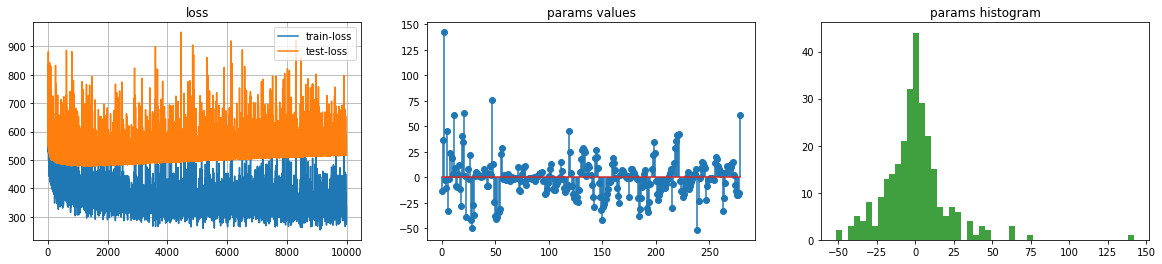

In [ ]:
model.train(batch_size=128)

Comment: With a smaller dataset, the model turns not to perform well on the train set (desspite the small loss) and also performs poorly on the test set. 

##L1 Regularization (Lasso Reg):
Lasso stands for Least Absolute **Shrinkage** and **Selection** Operator.

Lasso Regression is useful when some of the features are useless. It will set many of the parameters to zero.

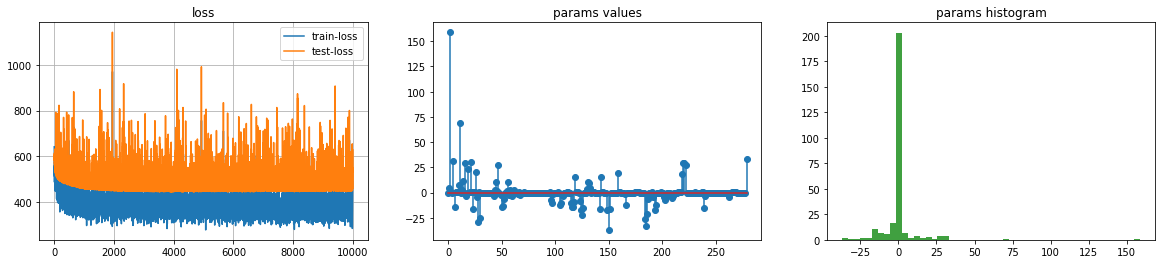

In [ ]:
# The larger your value of l1, the more likely some of the coefficients get closer to zero
model = LinearRegressionModel(dataset, l2=0.0, l1=2.5, lr = 0.001, epochs=10000)
model.train(batch_size=128)
#If you look the stem plot we will find that many of the parameters have values ~0

Comment: The lasso regression model, acts like a feature selection model, and remove irrelevant features from the data set (by shrinking the weights to zero), as a result, the train loss and the test loss are closed to each other, meaning the model, performs better after $l_{1}$regularization. The parameter values are smaller compared to the previous model, with most of them turning to zero (sparsity). The parameters follows a laplace distribution.

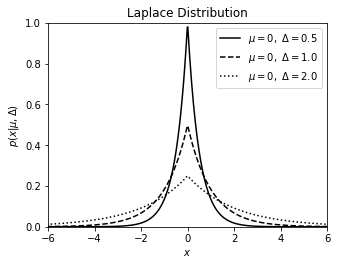

In [ ]:
#the parameters follow a laplace distribution with small var
import numpy as np
from scipy.stats import laplace
from matplotlib import pyplot as plt


delta_values = [0.5, 1.0, 2.0]
linestyles = ['-', '--', ':']
mu = 0
x = np.linspace(-10, 10, 1000)
fig, ax = plt.subplots(figsize=(5, 3.75))

for delta, ls in zip(delta_values, linestyles):
    dist = laplace(mu, delta)

    plt.plot(x, dist.pdf(x), ls=ls, c='black',
             label=r'$\mu=%i,\ \Delta=%.1f$' % (mu, delta))

plt.xlim(-6, 6)
plt.ylim(0, 1.0)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\Delta)$')
plt.title('Laplace Distribution')

plt.legend()
plt.show()

### Features Selection with L1 Regulariztion:

In [ ]:
threshold = 0.005
model.drop_features(threshold)

In [ ]:
model.train()

In [ ]:
model.theta.shape

In [ ]:

model.dataset.train_inputs.shape

##L2 Regularization (Ridge Reg):

When most of the features are useful, Ridge reg will shrink the parameters but it will not remove them totally.

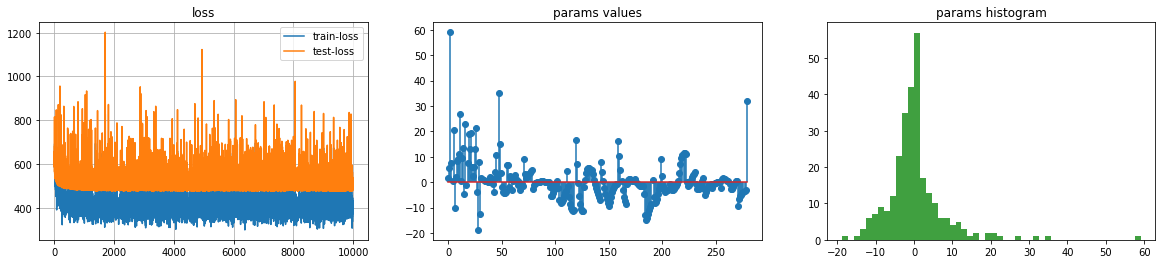

In [ ]:
# The larger your value of l2, the more likely your coefficients get smaller
model = LinearRegressionModel(dataset, l2=0.4, l1=0.0, lr=0.001, epochs=10000)
model.train(batch_size=128)

comment: The weights for $l_{2}$ regularization, model, are very small but doesn't completely shrinks to zero. We also notice the graph of the parameter histogram, seems to follow the assumption of a normal distribution.   

## Elastic Net

Elastic net combines both ridge reg and lasso reg

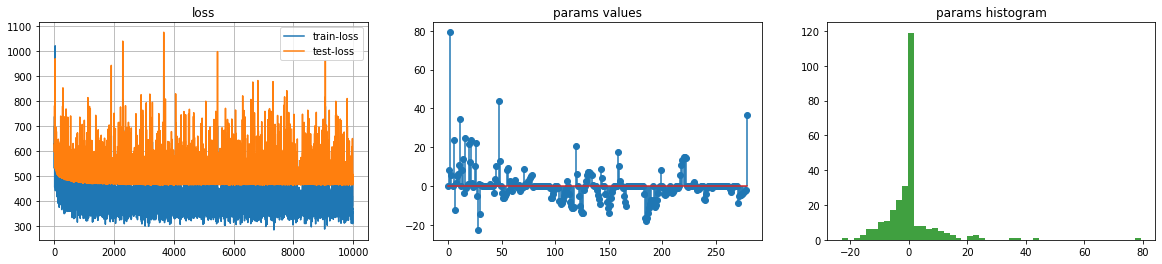

In [ ]:
model = LinearRegressionModel(dataset, l2=0.2, l1=0.8, lr = 0.001, epochs=10000)
model.train(batch_size=128)

The elastic net  regression model on the other hand is a combination of the two models $l_{1} and l_{2}$. We observe some of the parameters are very small and others completely turns to zero as seen on the parameter value graph. The test loss turns to be more stable and is  also higher than the train loss.